# Python MinBLEP Generator
An iPython port of [the MinBLEP generator from experimentalscene](http://www.experimentalscene.com/articles/minbleps.php)

This notebook takes a bottom-up approach to reconstructing the algorithms described there, and uses `numpy` where possible (most notably for sinc, fft/ifft, and automagically handling complex numbers).

First, some basic imports.

In [1]:
pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from itertools import izip

### Blackman Window

It's possible that numpy actually handles this, but I didn't find anything quickly, and it was simple enough to implement.

In [3]:
def blackman_window(length):
    for i in range(0, length):
        f1 = 2.0 * pi * i / length
        f2 = 2.0 * f1
        val = 0.42 - (0.5 * cos(f1)) + (0.08 * cos(f2))
        yield val

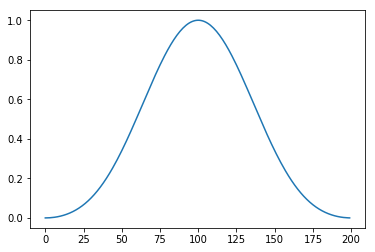

In [4]:
plot(list(blackman_window(200)))

### Generating a sinc buffer
From the algorithm, we use the buffer size and number of zero crossings as parameters to the sinc.

In the ExperimentalScene algorithm, they use a strange `b - a` construct as a replacement for `2.0 * zeroCrossings`.  My guess is that this is an attempt to pre-optimize the code for the compiler, which makes it a moot point in Python.

In [47]:
def sinc_buffer(size, zero_crossings=10):
    for i in range(0, size):
        r = float(i) / (float(size) - 1.0)
        yield sinc(float(-zero_crossings) + (r * 2.0 * zero_crossings))

The `yield`ing approach helps keep the code brief, and means that we don't generate more lists than we need to. But, we do need a `list` to pass to `plot`.

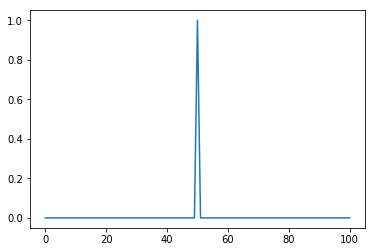

In [69]:
plot(list(sinc_buffer(101, 100)))

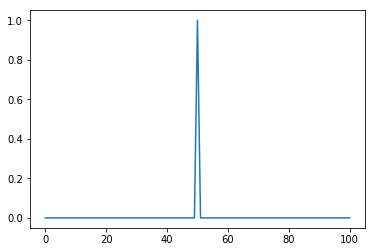

In [76]:
plot(sinc(linspace(-100, 100, 101)))

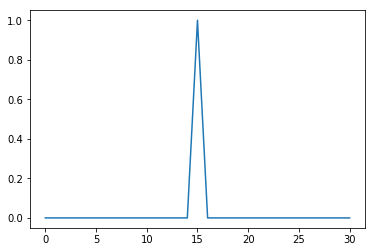

In [31]:
plot(list(sinc_buffer(31, 15)))

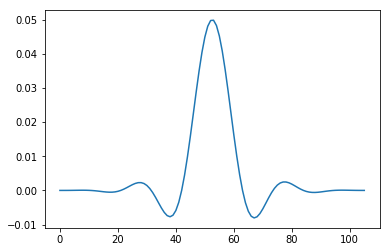

In [46]:
plot(list(windowed_sinc(blackman_window, 106, 100)))

Once more with the same size, and fewer crossings:

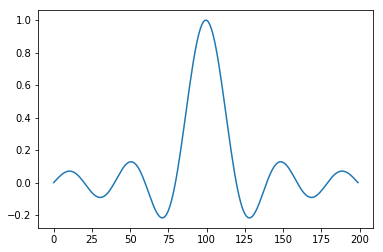

In [7]:
plot(list(sinc_buffer(200, 5)))

### Windowing the Sinc
The first conceptual stage of the ExperimentalScene code is to generate a windowed sinc, so here we have a generic way to apply a windowing function to the sinc.  In our case, we'll never pass anything other than `blackman_window`, but you could apply a different window for a different purpose if you wanted out.

In [8]:
def windowed_sinc(windowing_func, num_samples, zero_crossings=10):
    sinc_gen = sinc_buffer(num_samples, zero_crossings)
    for sinc, window in izip(sinc_gen, windowing_func(num_samples)):
        yield sinc * window

And again we're `yield`ing, so we have to make sure that the result is turned into a `list` for `plot`.

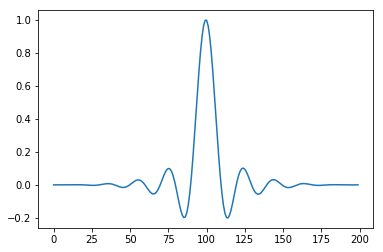

In [9]:
plot(list(windowed_sinc(blackman_window, 200)))

And again, this time with more zero crossings!

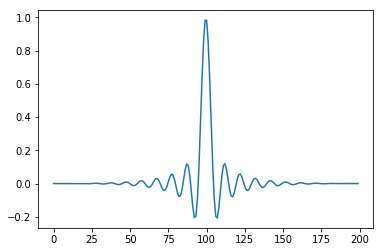

In [10]:
plot(list(windowed_sinc(blackman_window, 200, 20)))

### Cepstrum and Minimum Phase calculation
Next, the algorithm calculates the Cepstrum of the windowed sinc to get a Minimum Phase version.  Note that `log` and `abs` both come from `numpy` here (iPython Notebook's `pylab inline` function effectively calls `from numpy import *`, so if you use this in proper code, you should update this to read `numpy.log`, `numpy.abs`, etc. For the love of all that is holy, please do NOT simply `from numpy import *` to get this to work.  You will thank yourself later.)

In [11]:
def cepstrum(signal, size):
    fft_res = fft.fft(signal, size)
    log_abs = log(abs(fft_res))
    cep = fft.ifft(log_abs)
    return cep

The Cepstrum requires a bit more setup to illustrate, so let's make a test signal of some example size and plot it:

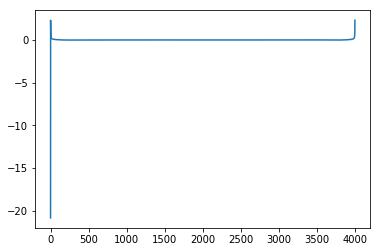

In [12]:
ex_size = 4000
sig = list(windowed_sinc(blackman_window, ex_size))
cep = cepstrum(sig, ex_size)
plot(cep.real)

And now computing the minimum phase:

In [13]:
def min_phase(signal, size):    
    half_size = size / 2
    real_time_domain = []
    
    for i in range(0, half_size):
        real_time_domain.append(2.0 * signal[i])
        
    if size % 2 == 1:
        real_time_domain.append(2.0 * signal[half_size])
        zero_start = half_size + 1
    else:
        zero_start = half_size
        
    for i in range(zero_start, size):
        real_time_domain.append(0.0)
    
    fft_res = fft.fft(real_time_domain, size)
    exp_freq = exp(fft_res)
    time_res = fft.ifft(exp_freq)
    return time_res.real

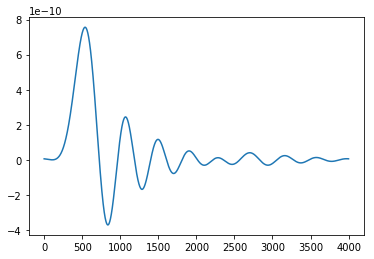

In [14]:
mp = min_phase(cep, ex_size)
plot(mp)

### Integrate and Normalize
The last steps are to integrate the minimum phase signal, and normalize it to be between 0 and 1.

In [15]:
def integrate(signal):
    running_val = 0.0
    for val in signal:
        running_val += val
        yield running_val

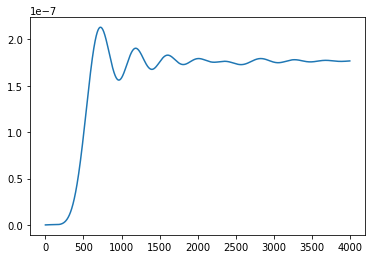

In [16]:
plot(list(integrate(mp)))

There's a bit of magic happening in the normalization: Since the MinBLEP signal is supposed to be a band-limited step function, we know it should converge on 1.0.  And since we know that the Gibbs ripples slowly converge to a fixed value, we just grab the last value of the signal array to get the scaling factor that will turn value that the Gibbs ripple converges onto into 1.

In [17]:
def normalize(signal):
    sig = list(signal)
    scale = 1.0 / sig[-1]
    normalized = [x * scale for x in sig]
    return normalized

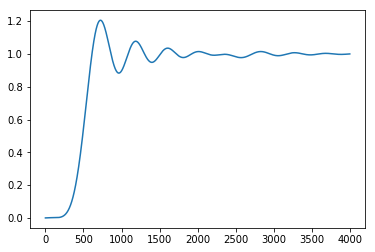

In [18]:
normalized_ex = normalize(integrate(mp))
plot(normalized_ex)

Hey, that looks like a MinBLEP!


### Bringing it all together
Finally, we take all of these pieces and put them into the core algorithm shown in the ExperimentalScene code: a function that accepts the number of zero crossings, and, in their terms, "oversampling", but what seems to me to be the sample rate of the generated signal.

I still don't quite understand the correct parameters to pass to this function to use in my signal processing, but at least this will make it somewhat easy to experiment with generating look-up tables with different parameters.

In [23]:
def generate_min_blep(zero_crossings, oversample_factor):
    size = int(zero_crossings * 2 * oversample_factor) + 1
    signal = list(windowed_sinc(blackman_window, size, zero_crossings))
    cep = cepstrum(signal, size)
    mp = min_phase(cep, size)
    minblep = normalize(integrate(mp))
    return minblep

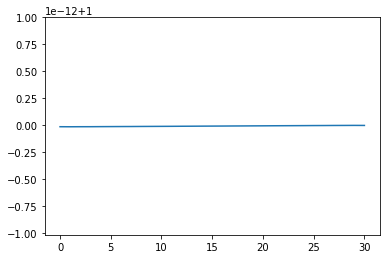

In [27]:
plot(generate_min_blep(15, 1))

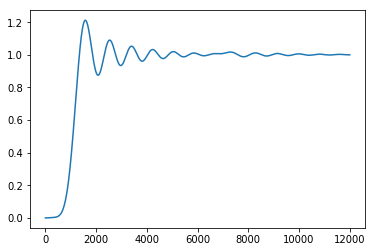

In [24]:
plot(generate_min_blep(15, 400))

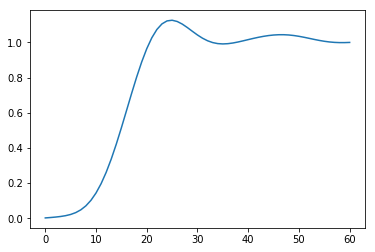

In [25]:
plot(generate_min_blep(3, 10))

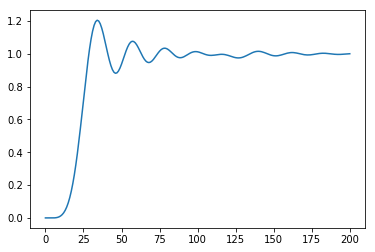

In [26]:
plot(generate_min_blep(10, 10))